# Matrix Fatorization

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-03-25 06:23:00.434326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 06:23:00.600651: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-25 06:23:02.477976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriat

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16247585506555452368
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48974397440
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 9331564724950153389
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.optimizers import Adam
from keras.models import Model

### 데이터 테이블 생성

In [8]:
table_df = pd.read_csv('../data/ulsan_rest_table_ver3.csv')
table_df

,p_id,place_id,u_id,user_id,score,comment
0,13,가천린포크,24544,ㆍ,4,생각 보다 고기부위가 다양하지 않음 그래도 된장 찌게 맛은 좋음
1,121,로망스아구찜,24544,ㆍ,5,맛과 서비스가대만족입니다.한달에 네번 가야 한 듯
2,139,메이즈메이즈,24544,ㆍ,5,라떼 킹 맛집 슈페너도 맛있지만 라떼를 드세요 후회안함 믿고 잡솨봐
3,170,백년본가김치찜,24544,ㆍ,3,음식은 맛있습니다. 4명이 가시면 반드시 2명씩 따로 앉기를 강추합니...
4,255,스타벅스 울산신복점,24544,ㆍ,4,NaN
...,...,...,...,...,...,...
54495,445,퐁당퐁당 본점,1,1,5,얼큰버섯샤브도 맛있는데 신메뉴도 맛있어요! 먹어본 칼국수중 가장 쫄깃쫄깃해요!
54496,465,해마지,1,1,4,NaN
54497,159,바다바라기 본점,0,0,1,인생최악의 킹크랩 이였습니다. 게의 상태가 안좋은 건지 잘못찐건지.킹크랩의 고유의 ...
54498,176,보리꽃,0,0,1,식당 리뷰 불친절하고 안좋아도 잘 안남기는데 진짜 최악ㅋㅋ우리보다 늦게 온 테이블들...


In [9]:
print(table_df.isnull().sum())
table_df.drop(columns='comment', inplace=True)
table_df.dropna(axis=0, how='any', inplace=True)

p_id            0
place_id        0
u_id            0
user_id         0
score           0
comment     14275
dtype: int64


In [10]:
table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54500 entries, 0 to 54499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   p_id      54500 non-null  int64 
 1   place_id  54500 non-null  object
 2   u_id      54500 non-null  int64 
 3   user_id   54500 non-null  object
 4   score     54500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


In [11]:
data_df = table_df[['u_id', 'p_id', 'score']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54500 entries, 0 to 54499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u_id    54500 non-null  int64
 1   p_id    54500 non-null  int64
 2   score   54500 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


### Train, Test split

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2, random_state=42)

In [15]:
n_users = data_df.u_id.unique().shape[0]
n_places = data_df.p_id.unique().shape[0]
print(n_users, n_places)

24545 492


In [25]:
n_users = data_df.u_id.max()
n_places = data_df.p_id.max()
print(n_users, n_places)

24545 491


In [24]:
tf.keras.backend.clear_session()

### callback

In [17]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

### Model

In [26]:
latent_dim = 100 ## 잠재요인

# creating book embedding path
place_input = Input(shape=[1], name="Place-Input")
place_embedding = Embedding(n_places+1, latent_dim, name="Place-Embedding")(place_input)
place_vec = Flatten(name="Flatten-Places")(place_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1,latent_dim, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([place_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, place_input], out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Place-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Place-Embedding (Embedding)    (None, 1, 100)       49200       ['Place-Input[0][0]']            
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 100)       2454600     ['User-Input[0][0]']             
                                                                                              

In [28]:
history = model.fit(x=[np.array(train.u_id), np.array(train.p_id)],y= np.array(train.score), validation_split=0.2, epochs=100, verbose=1, callbacks=[earlystopping])

Epoch 1/100
1090/1090 [==============================] - 10s 8ms/step - loss: 1.4405 - val_loss: 1.2188
Epoch 2/100
1090/1090 [==============================] - 7s 7ms/step - loss: 0.8696 - val_loss: 1.3275
Epoch 3/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.6497 - val_loss: 1.3861
Epoch 4/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.5234 - val_loss: 1.2824
Epoch 5/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.4445 - val_loss: 1.3939
Epoch 6/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.3848 - val_loss: 1.3186
Epoch 7/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.3272 - val_loss: 1.3717
Epoch 8/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.2820 - val_loss: 1.4347
Epoch 9/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.2471 - val_loss: 1.3703
Epoch 10/100
1090/1090 [==============================] - 7s 6ms/step - 

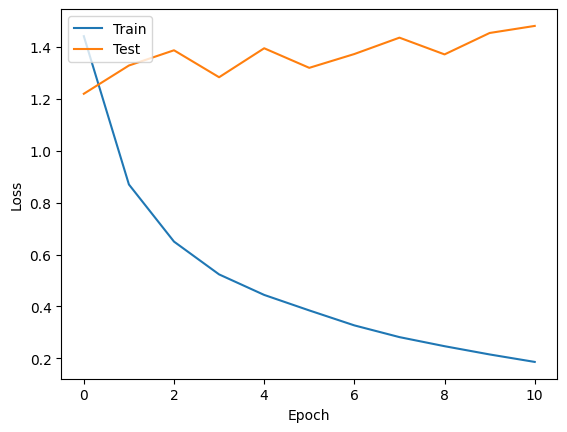

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.show()

In [30]:
model.evaluate([test.u_id, test.p_id], test.score)

341/341 [==============================] - 1s 4ms/step - loss: 1.4741


1.4741182327270508

In [31]:
from sklearn.metrics import mean_squared_error
y_prob = model.predict([test.u_id, test.p_id])
y_true = test.score
mean_squared_error(y_true, np.round(y_prob))**0.5

341/341 [==============================] - 1s 3ms/step


1.2345931246715407

In [ ]:
id_place = range(1,20)

# Creating dataset for making recommendations for the first user
place_data = np.array(list(set(data_df.p_id)))
place_data[:10]

id_user = 3
user = np.array([id_user for i in range(len(place_data))])
user[:10]

predictions = model.predict([user, place_data])

predictions = np.array([a[0] for a in predictions])

recommended_tourism_ids = (-predictions).argsort()[:10]

recommended_tourism_ids

# print predicted scores
predictions[recommended_tourism_ids]

17/17 [==============================] - 0s 2ms/step


array([5.4001794, 5.3755636, 5.3753176, 5.3332033, 5.3326054, 5.3321533,
       5.324966 , 5.3010364, 5.2935624, 5.2885942], dtype=float32)